# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 292 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

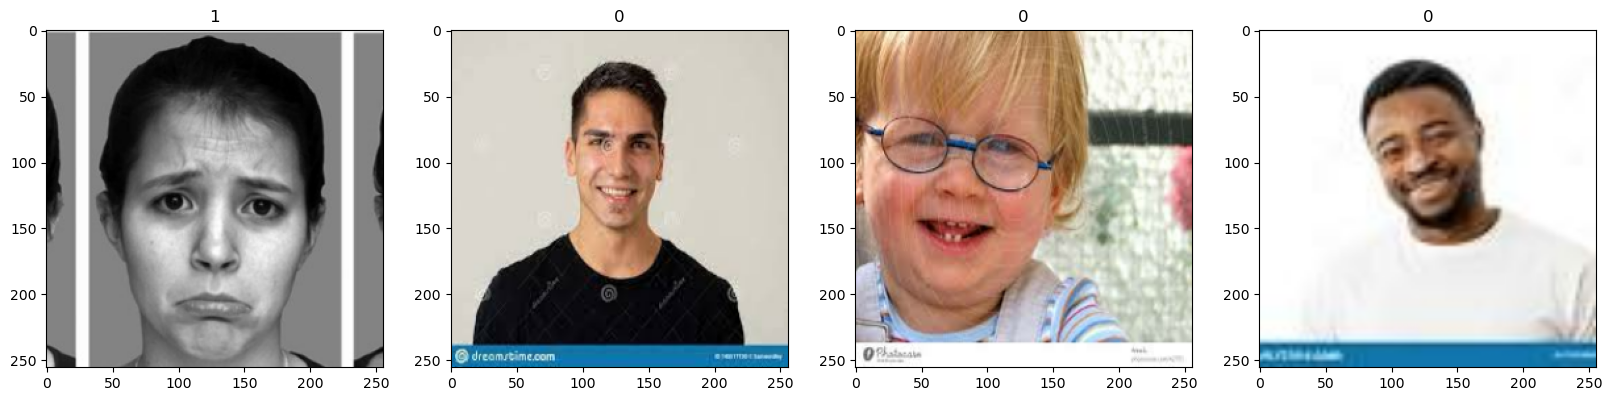

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.3453891 , 0.51401657, 0.58852637],
          [0.35381433, 0.5224418 , 0.5969516 ],
          [0.36369485, 0.5323223 , 0.6068321 ],
          ...,
          [0.39433977, 0.59579504, 0.6759651 ],
          [0.39912683, 0.58867186, 0.6745098 ],
          [0.4       , 0.5882353 , 0.6745098 ]],
 
         [[0.34754997, 0.5161774 , 0.5906872 ],
          [0.35406417, 0.5226916 , 0.5972014 ],
          [0.36552262, 0.53415006, 0.60865986],
          ...,
          [0.39491835, 0.5976228 , 0.67737645],
          [0.40137103, 0.59091604, 0.676754  ],
          [0.4000833 , 0.5883186 , 0.6745931 ]],
 
         [[0.35033283, 0.5189603 , 0.5934701 ],
          [0.3563774 , 0.52500486, 0.59951466],
          [0.3682236 , 0.53685105, 0.61136085],
          ...,
          [0.39584997, 0.59948814, 0.6789305 ],
          [0.4021732 , 0.59371936, 0.68055785],
          [0.40010375, 0.5905909 , 0.67799133]],
 
         ...,
 
         [[0.01779259, 0.06485141, 0.06485141],
          [0.03024

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

7

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 6s 639ms/step - loss: 0.7118 - accuracy: 0.5670 - val_loss: 0.6365 - val_accuracy: 0.5781
Epoch 2/20
7/7 [==============================] - 5s 623ms/step - loss: 0.5887 - accuracy: 0.6518 - val_loss: 0.5745 - val_accuracy: 0.8750
Epoch 3/20
7/7 [==============================] - 5s 627ms/step - loss: 0.5489 - accuracy: 0.7366 - val_loss: 0.5444 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 5s 631ms/step - loss: 0.5034 - accuracy: 0.7946 - val_loss: 0.4372 - val_accuracy: 0.8438
Epoch 5/20
7/7 [==============================] - 5s 628ms/step - loss: 0.4398 - accuracy: 0.8214 - val_loss: 0.4266 - val_accuracy: 0.7969
Epoch 6/20
7/7 [==============================] - 5s 626ms/step - loss: 0.3437 - accuracy: 0.8616 - val_loss: 0.2959 - val_accuracy: 0.9219
Epoch 7/20
7/7 [==============================] - 5s 636ms/step - loss: 0.3034 - accuracy: 0.8571 - val_loss: 0.2750 - val_accuracy: 0.9062
Epoch 8/20
7/7 [====

# 8. Plot Performance

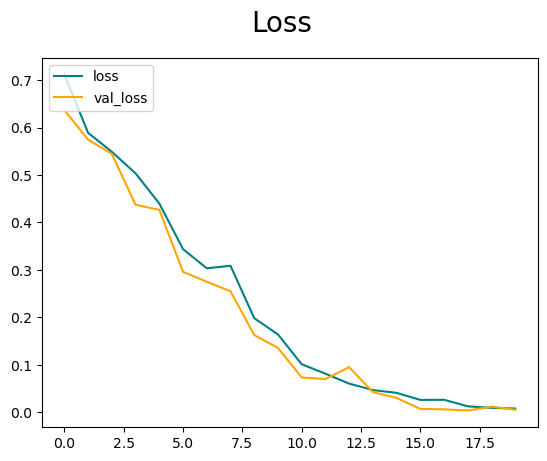

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

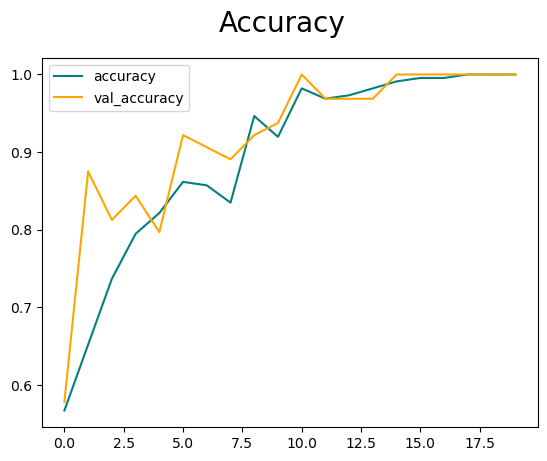

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 89ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [37]:
import cv2

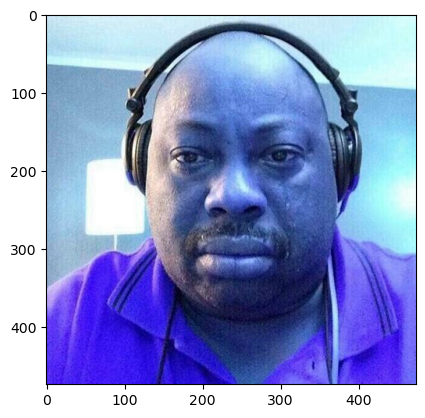

In [39]:
img = cv2.imread('yoyo.jpg')
plt.imshow(img)
plt.show()

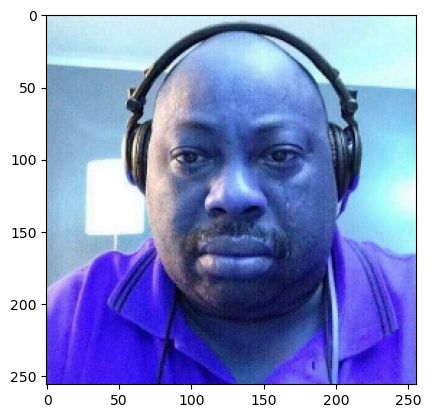

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 26ms/step


In [42]:
yhat

array([[1.]], dtype=float32)

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


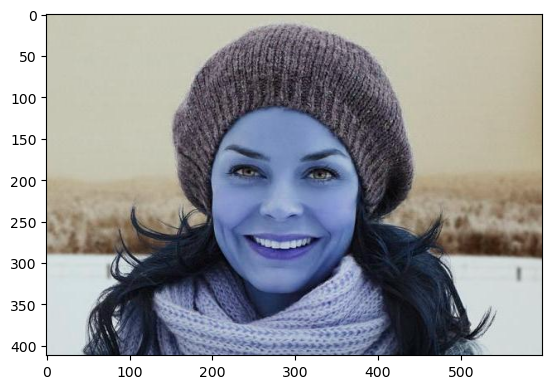

In [50]:
img = cv2.imread('hr_Happy_Happy_1-3818251831.jpg')
plt.imshow(img)
plt.show()

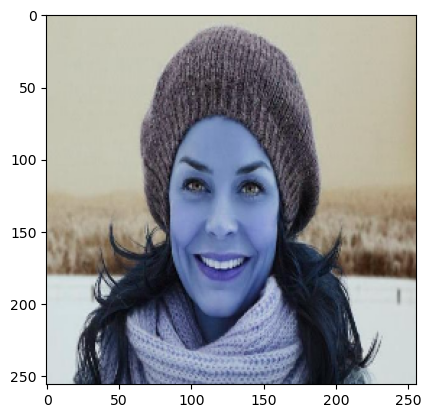

In [51]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [52]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 28ms/step


In [53]:
yhat

array([[0.99183035]], dtype=float32)

In [54]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


Mistakes were made